In [2]:
import rioxarray as rxr
import xarray as xr
import geopandas as gpd
import pandas as pd
import numpy as np
import os
from glob import glob
from landsat_processing_utils import landsat_l2_scaling, run_qa_parser, qa_pixel_interp_conservative
import earthpy.spatial as es
import earthpy.plot as ep
import rasterstats
import matplotlib.pyplot as plt

In [3]:
# target stacked landsat files
files = glob(os.path.join('LC08*/*STACKED.tif'))

files

['LC08_L2SP_113037_20210104_20210308_02_T1\\LC08_L2SP_113037_20210104_20210308_02_T1_STACKED.tif',
 'LC08_L2SP_113037_20210120_20210307_02_T1\\LC08_L2SP_113037_20210120_20210307_02_T1_STACKED.tif',
 'LC08_L2SP_113037_20210221_20210303_02_T1\\LC08_L2SP_113037_20210221_20210303_02_T1_STACKED.tif',
 'LC08_L2SP_113037_20210325_20210402_02_T1\\LC08_L2SP_113037_20210325_20210402_02_T1_STACKED.tif',
 'LC08_L2SP_113037_20211003_20211013_02_T1\\LC08_L2SP_113037_20211003_20211013_02_T1_STACKED.tif',
 'LC08_L2SP_113037_20211120_20211130_02_T1\\LC08_L2SP_113037_20211120_20211130_02_T1_STACKED.tif',
 'LC08_L2SP_113037_20211222_20211230_02_T1\\LC08_L2SP_113037_20211222_20211230_02_T1_STACKED.tif']

In [4]:
cl_masks = glob(os.path.join('LC08*/*QA_PIXEL_crop.tif'))

cl_masks

['LC08_L2SP_113037_20210104_20210308_02_T1\\LC08_L2SP_113037_20210104_20210308_02_T1_QA_PIXEL_crop.TIF',
 'LC08_L2SP_113037_20210120_20210307_02_T1\\LC08_L2SP_113037_20210120_20210307_02_T1_QA_PIXEL_crop.TIF',
 'LC08_L2SP_113037_20210221_20210303_02_T1\\LC08_L2SP_113037_20210221_20210303_02_T1_QA_PIXEL_crop.TIF',
 'LC08_L2SP_113037_20210325_20210402_02_T1\\LC08_L2SP_113037_20210325_20210402_02_T1_QA_PIXEL_crop.TIF',
 'LC08_L2SP_113037_20211003_20211013_02_T1\\LC08_L2SP_113037_20211003_20211013_02_T1_QA_PIXEL_crop.TIF',
 'LC08_L2SP_113037_20211120_20211130_02_T1\\LC08_L2SP_113037_20211120_20211130_02_T1_QA_PIXEL_crop.TIF',
 'LC08_L2SP_113037_20211222_20211230_02_T1\\LC08_L2SP_113037_20211222_20211230_02_T1_QA_PIXEL_crop.TIF']

<Axes: >

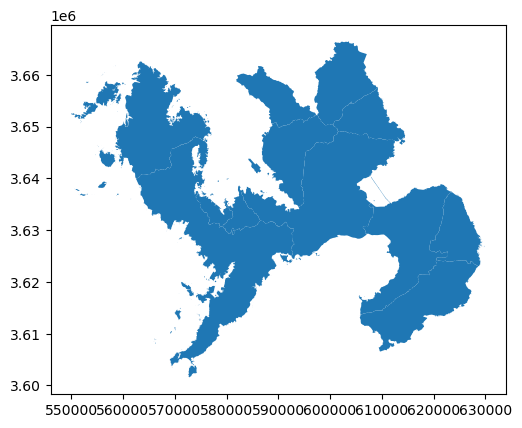

In [5]:
geometries = gpd.read_file('mun_bounds_cleaned.geojson')

geometries = geometries.to_crs(es.crs_check(files[0]))

geometries.plot()

In [6]:
from datetime import datetime

# get dates from landsat folder names
landsat = glob('LC08*')

dates = [name.split('_')[3] for name in landsat]
datetimes = [datetime.strptime(date, '%Y%m%d') for date in dates]
date_strings = [date.strftime('%d %B %Y') for date in datetimes]

pd.Index(date_strings)

Index(['04 January 2021', '20 January 2021', '21 February 2021',
       '25 March 2021', '03 October 2021', '20 November 2021',
       '22 December 2021'],
      dtype='object')

In [8]:
%%time
time_series = list()

for idx, file in enumerate(files):
    # clip before loading - should be much faster (saves about 2 seconds)
    with rxr.open_rasterio(file, masked = True).rio.clip(geometries.geometry, from_disk = True) as ds:
        # this looks like it works to prevent shit from being stored in memory
        # a bit annoying but at least i won't run out of memory now
        data = ds.load()
        ds.close()
    # calculate reflectance first
    optical = data[:-1] * 0.0000275 - 0.2

    # uncomment these two if you want to analyse the thermal band
    # thermal = ds[-1] * 0.00341802 + 149.0
    # stack = xr.concat([optical, thermal], dim="band") 
        
    # clip data to remove any reflectances above 1 and reflectances below 0 (generally occurs in water)
    optical = optical.clip(min = 0, max = 1, keep_attrs= True)

    ndvi = (optical[4] - optical[3]) / (optical[4] + optical[3])

    time_series.append(ndvi)

CPU times: total: 12.3 s
Wall time: 12.9 s


In [78]:
# band_list contains list of bands - use xr concat to combine them
# note that you can rename the axis by which you are combining by using a pd.Index
# the name of the index will be used as the dimension name
ndvi_time = xr.concat(time_series, pd.Index(date_strings, name = 'date'))

In [ ]:
# load in cloud masks
masks = list()

for cl_mask in cl_masks:
    with rxr.open_rasterio(cl_mask, masked = True).rio.clip(geometries.geometry, from_disk = True) as ds:
        # convert to np.uint16
        data = ds.astype(np.uint16).squeeze()
        ds.close()
        
    # run conservative cloud analysis
    result = run_qa_parser(data, qa_pixel_interp_conservative)
    masks.append(result)

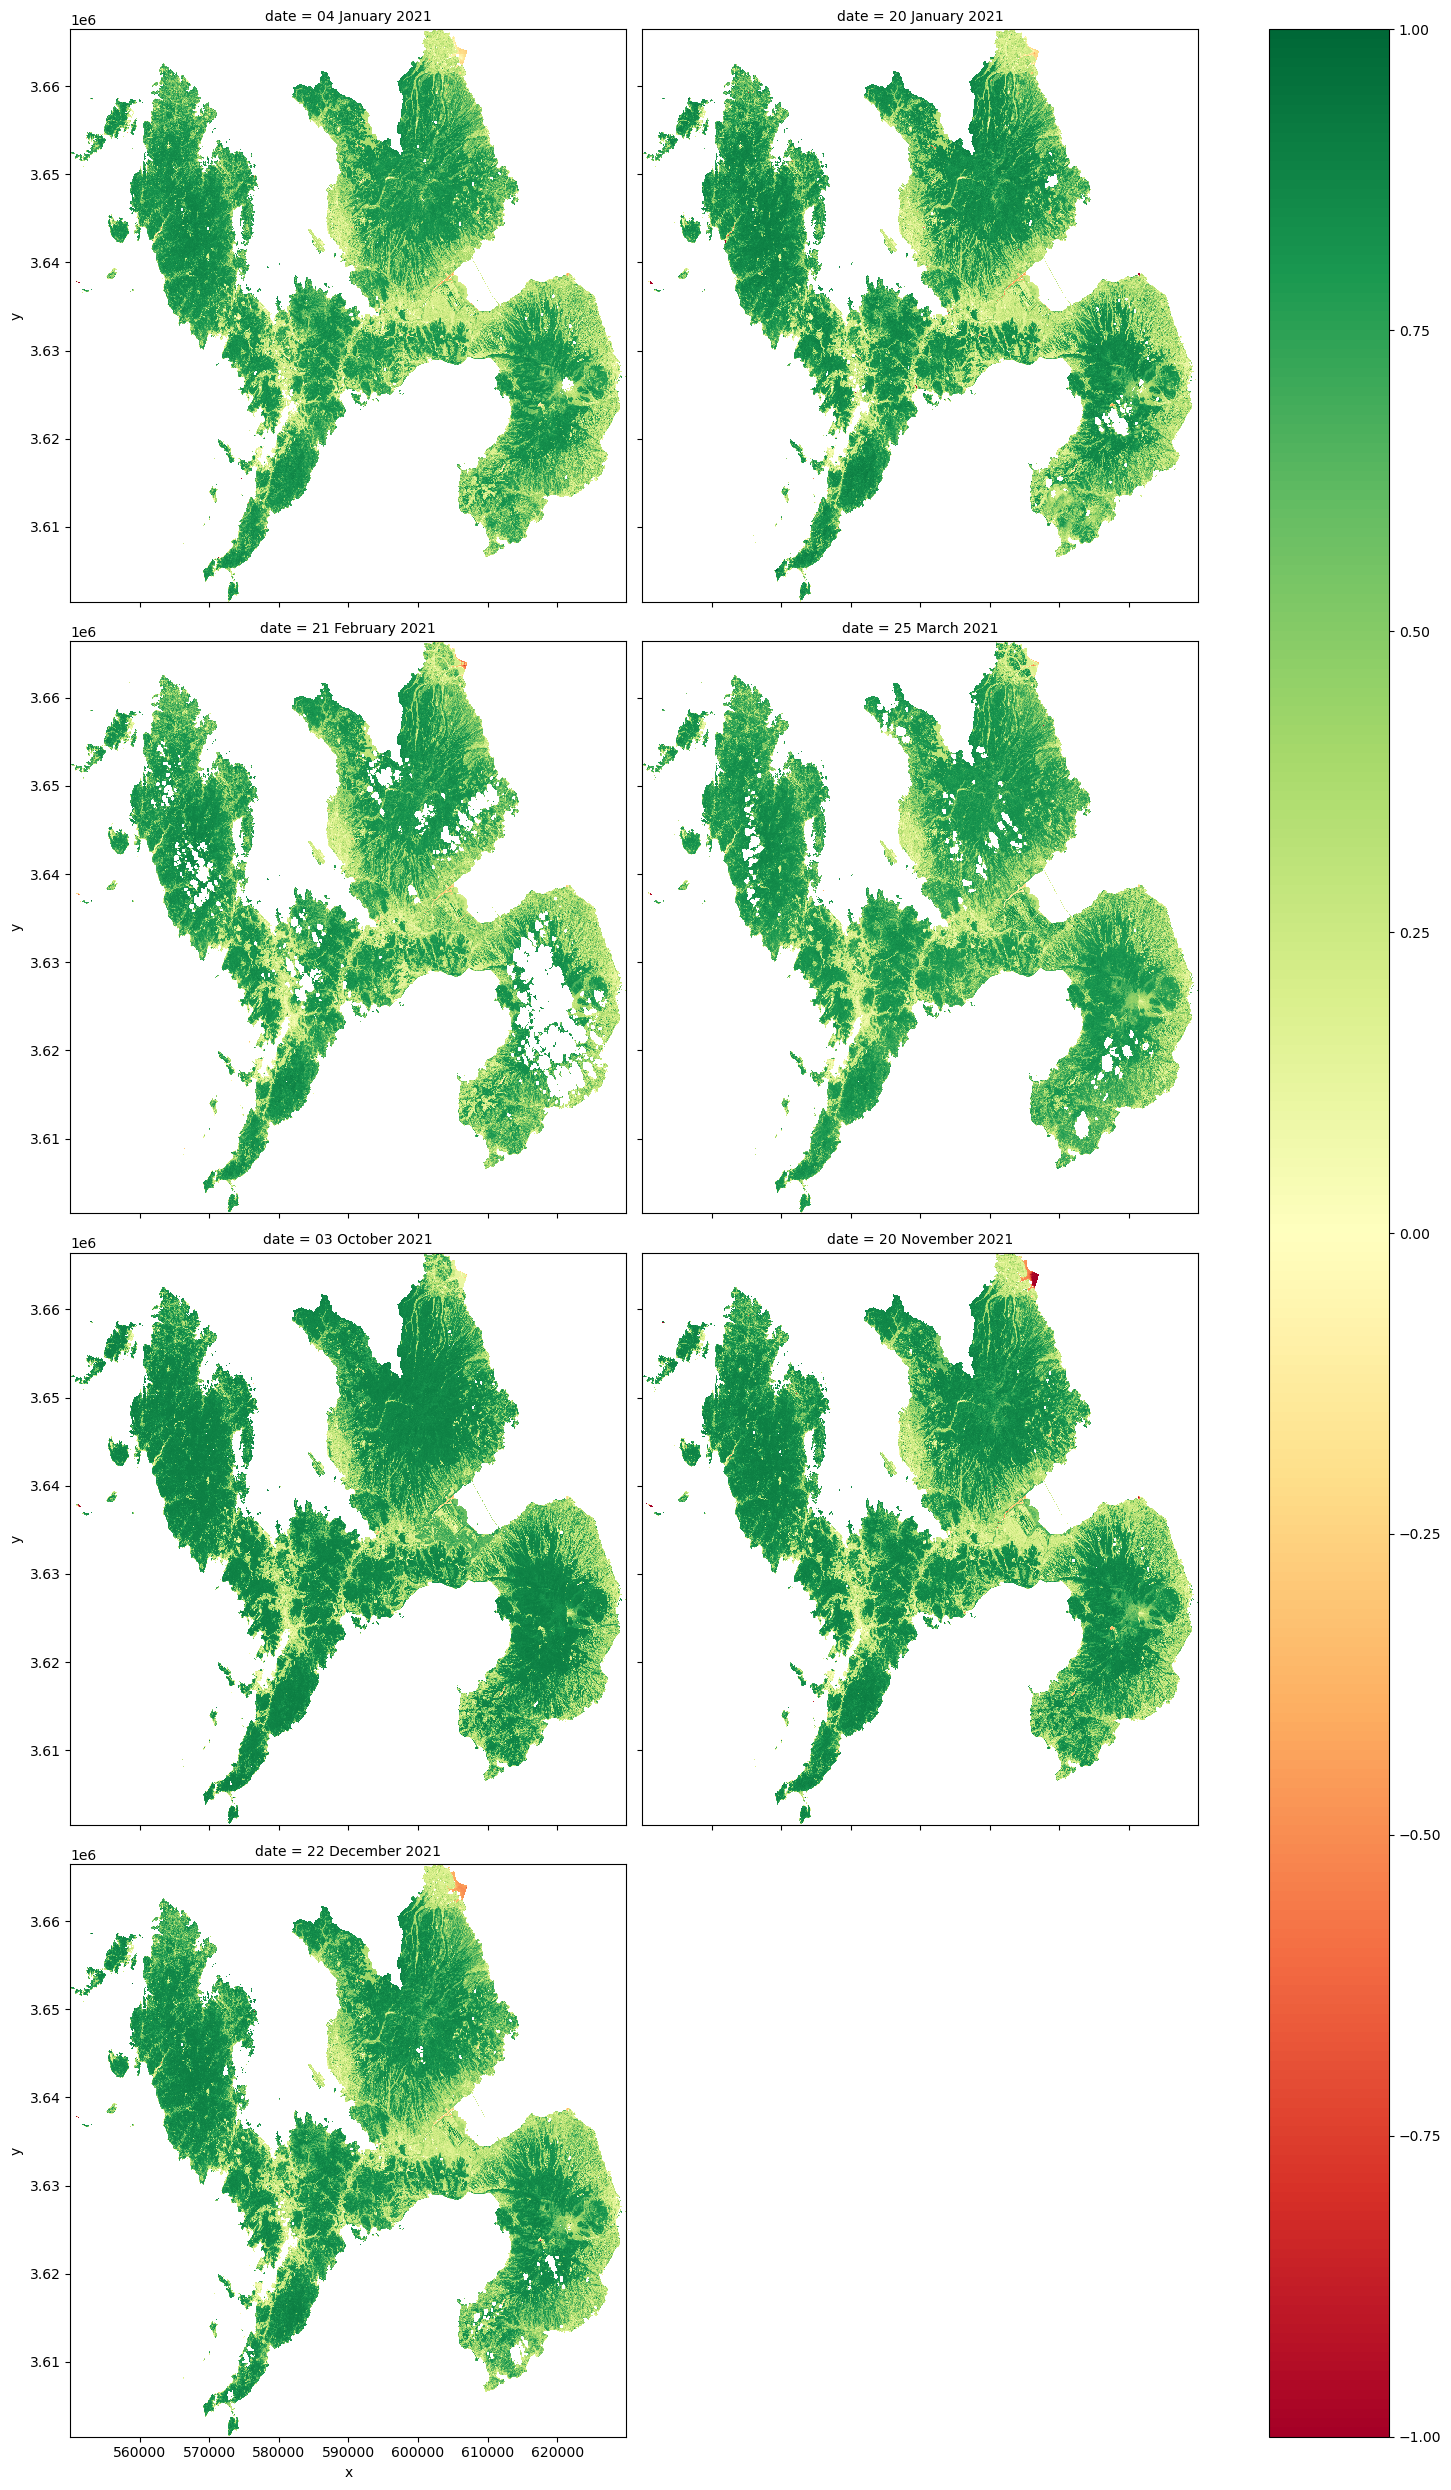

In [151]:
# stack masks
stacked_masks = np.stack(masks)

# mask the stacked ndvi data
ndvi_masked = ndvi_time.where(np.invert(stacked_masks), np.nan)


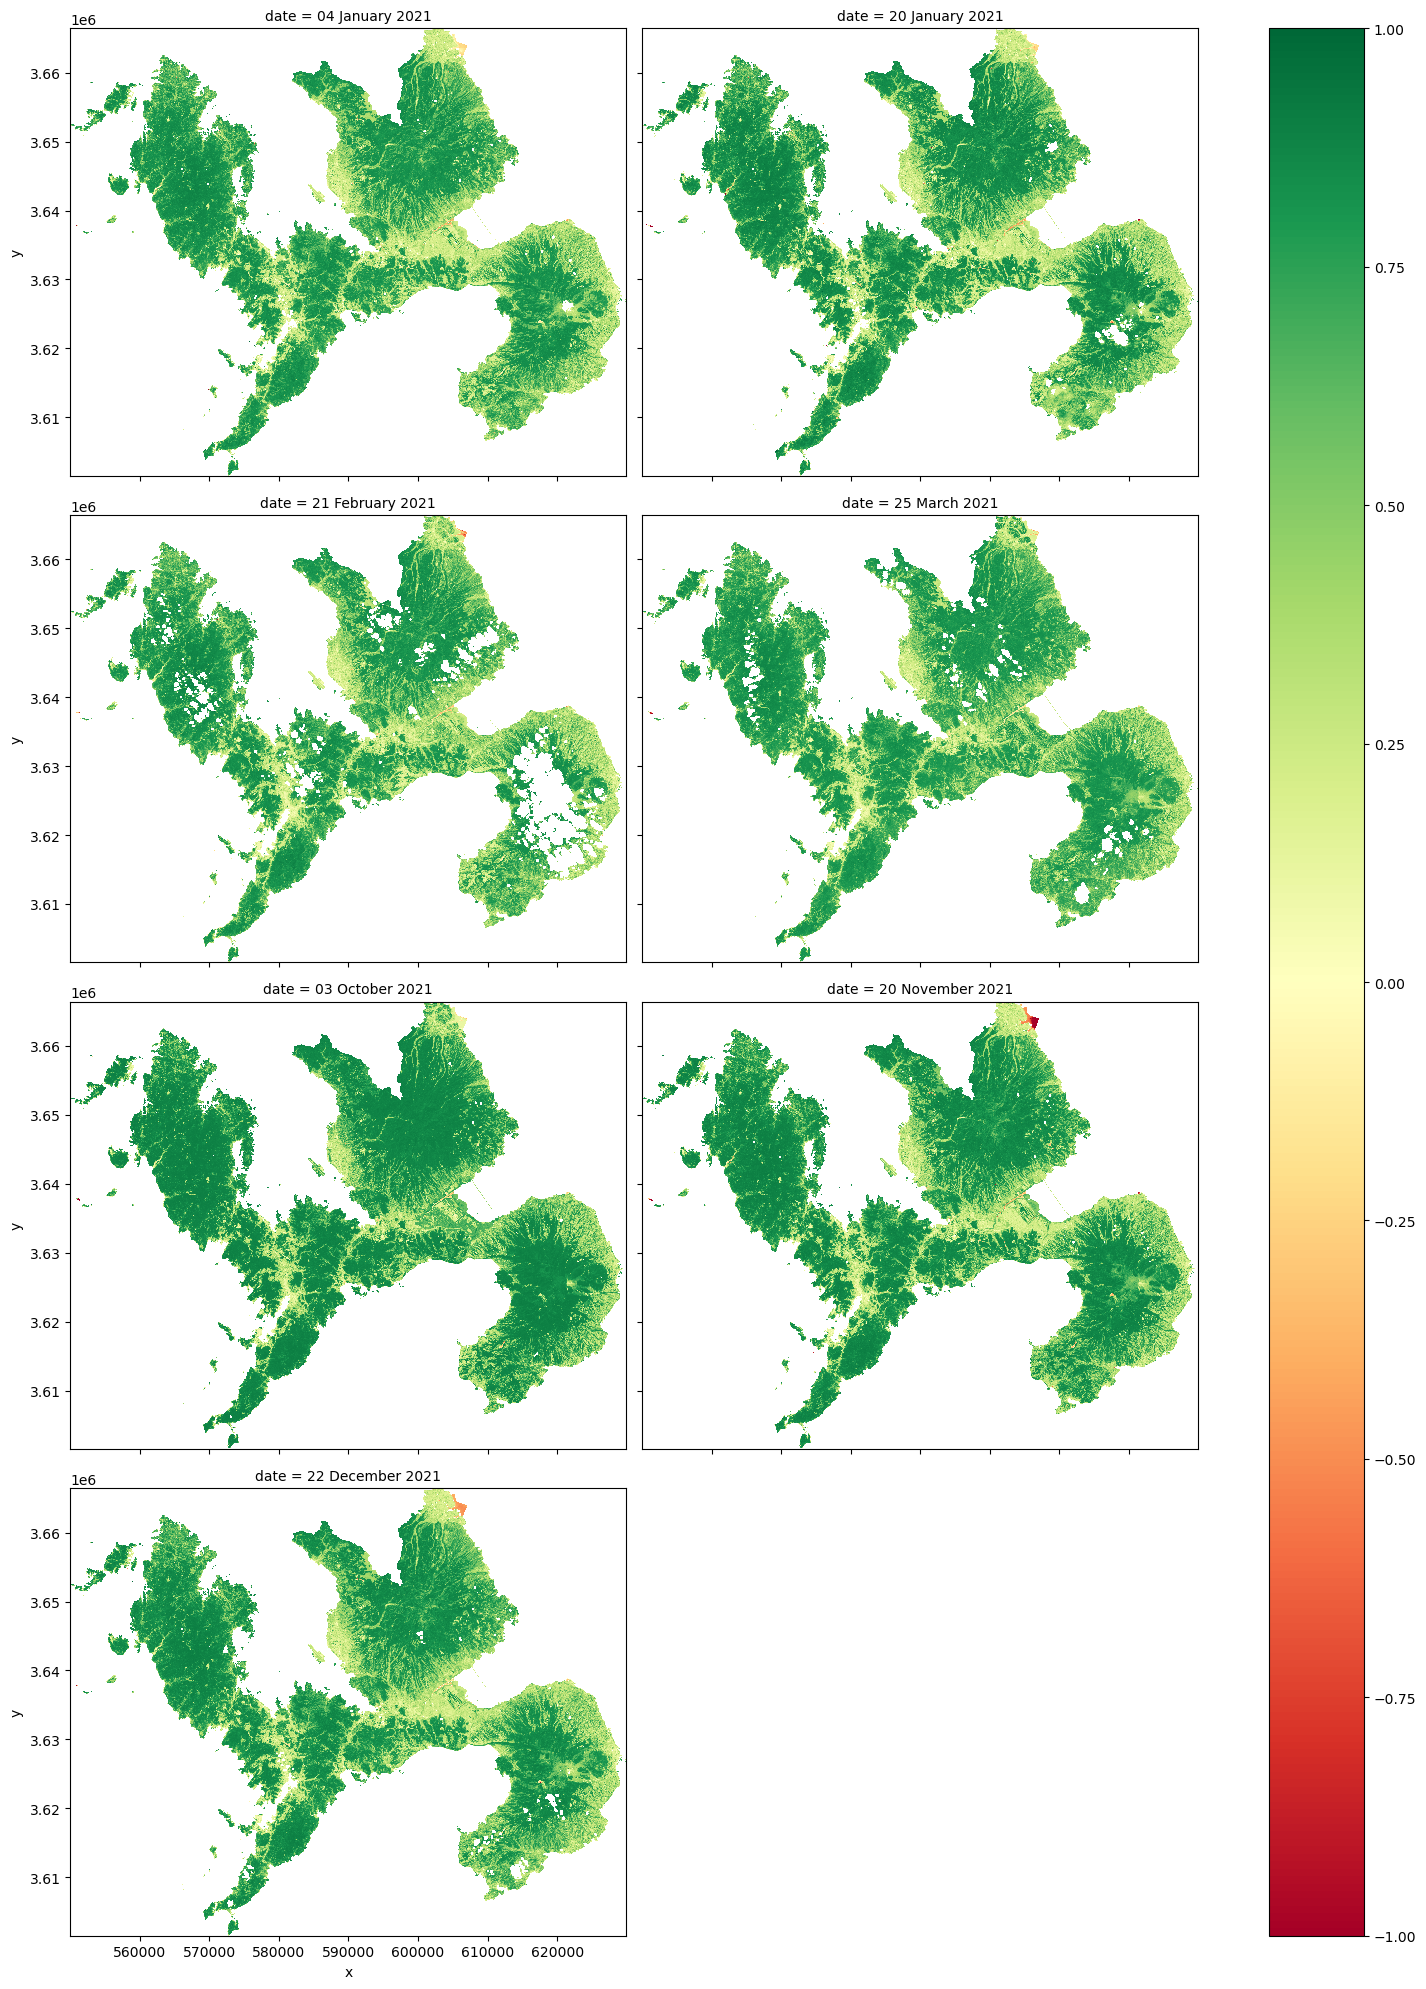

In [154]:
# produce graphs
ndvi_masked.plot(col = 'date', col_wrap = 2, cmap = 'RdYlGn', figsize = (15,20))

In [80]:
ndvi_masked

<xarray.DataArray (date: 7, y: 2164, x: 2664)>
array([[[nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan],
        ...,
        [nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan]],

       [[nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan],
        ...,
        [nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan]],

       [[nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan],
        ...,
...
        ...,
        [nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan]],

       [[nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan],
        ...,
        [nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan]],

       [[nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan],
        ...,
        [nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan]]])
Coordinates:
  * x            (x) float64 5.5e+05 5.5e+05 5.501e+05 ... 6.299e+05 6.299e+05
  * y            (y) float64 3.666e+06 3.666e+06 ... 3.602e+06 3.602e+06
    spatial_ref  int32 0
  * date         (date) object '04 January 2021' ... '22 December 2021'

In [87]:
# unfortunately, can't do rasterstats on a 3D data array
for idx in range(ndvi_time.shape[0]):
    stats = rasterstats.zonal_stats(geometries,          # can also give filepath to geojson object
                                    ndvi_time[idx].data, # numpy array or path to raster
                                    affine = ndvi_time.rio.transform(),
                                    nodata = np.nan,
                                    stats = "mean median")
    
    stats = pd.DataFrame(stats)
    # Add prefix does NOT automatically add an underscore
    stats = stats.add_prefix(f"{ndvi_time.date[idx].item()}_")
    
    geometries = pd.concat([geometries, stats], axis = 1)

geometries

name:en        area  \
0              Unzen  208.396449   
1            Togitsu   20.879353   
2             Saikai  232.782378   
3              Omura  126.519727   
4           Nagasaki  405.712597   
5             Nagayo   28.744017   
6          Shimabara   82.896250   
7     Higashi-Sonogi   74.189358   
8   Minami-Shimabara  170.110766   
9            Isahaya  329.083335   
10           Kashima  114.757744   
11              Tara   74.200951   

                                             geometry  04 January 2021_mean  \
0   MULTIPOLYGON (((606635.330 3617190.342, 606631...              0.599197   
1   MULTIPOLYGON (((575820.531 3637110.984, 575827...              0.563913   
2   MULTIPOLYGON (((550528.743 3652271.062, 550517...              0.725462   
3   MULTIPOLYGON (((585408.055 3641409.508, 585396...              0.577328   
4   MULTIPOLYGON (((551699.236 3636587.989, 551697...              0.662835   
5   MULTIPOLYGON (((580289.037 3635102.766, 580295...              0.606282   
6   MULTIPOLYGON (((628768.656 3625254.691, 628765...              0.496769   
7   MULTIPOLYGON (((585736.548 3655197.079, 585740...              0.675536   
8   MULTIPOLYGON (((611641.602 3607560.887, 611644...              0.566777   
9   MULTIPOLYGON (((593383.615 3624357.660, 593391...              0.574932   
10  MULTIPOLYGON (((606931.438 3663577.401, 606452...              0.591524   
11  MULTIPOLYGON (((613344.549 3650343.490, 613356...              0.677781   

    04 January 2021_median  20 January 2021_mean  20 January 2021_median  \
0                 0.664825              0.610322                0.681269   
1                 0.648267              0.577508                0.667027   
2                 0.788513              0.738882                0.812147   
3                 0.650756              0.596836                0.692919   
4                 0.764712              0.679201                0.793189   
5                 0.687095              0.621473                0.708386   
6                 0.478664              0.508110                0.477375   
7                 0.765546              0.689684                0.795937   
8                 0.595105              0.544110                0.542951   
9                 0.655190              0.586571                0.670405   
10                0.684035              0.617451                0.729975   
11                0.732686              0.702052                0.773950   

    21 February 2021_mean  21 February 2021_median  25 March 2021_mean  \
0                0.532124                 0.548884            0.645375   
1                0.558897                 0.636043            0.574021   
2                0.699127                 0.761695            0.711426   
3                0.567730                 0.637393            0.595125   
4                0.645373                 0.749581            0.659296   
5                0.579001                 0.647010            0.614674   
6                0.471666                 0.438765            0.523947   
7                0.658409                 0.746110            0.648396   
8                0.502811                 0.519006            0.583678   
9                0.570242                 0.625830            0.610624   
10               0.614377                 0.690344            0.642170   
11               0.657837                 0.723268            0.692193   

    25 March 2021_median  03 October 2021_mean  03 October 2021_median  \
0               0.717125              0.706676                0.828479   
1               0.672505              0.649818                0.779716   
2               0.770975              0.795085                0.861938   
3               0.688489              0.684515                0.812151   
4               0.757655              0.743961                0.860153   
5               0.708823              0.683929                0.792650   
6               0.531603              0.617209

In [132]:
mean_column_indices = [idx for idx, col in enumerate(geometries.columns) if 'median' in col]

mean_column_indices

[4, 6, 8, 10, 12, 14, 16]

Text(0.5, 0.92, 'Mean NDVI in Nagasaki Municipalities in 2021')

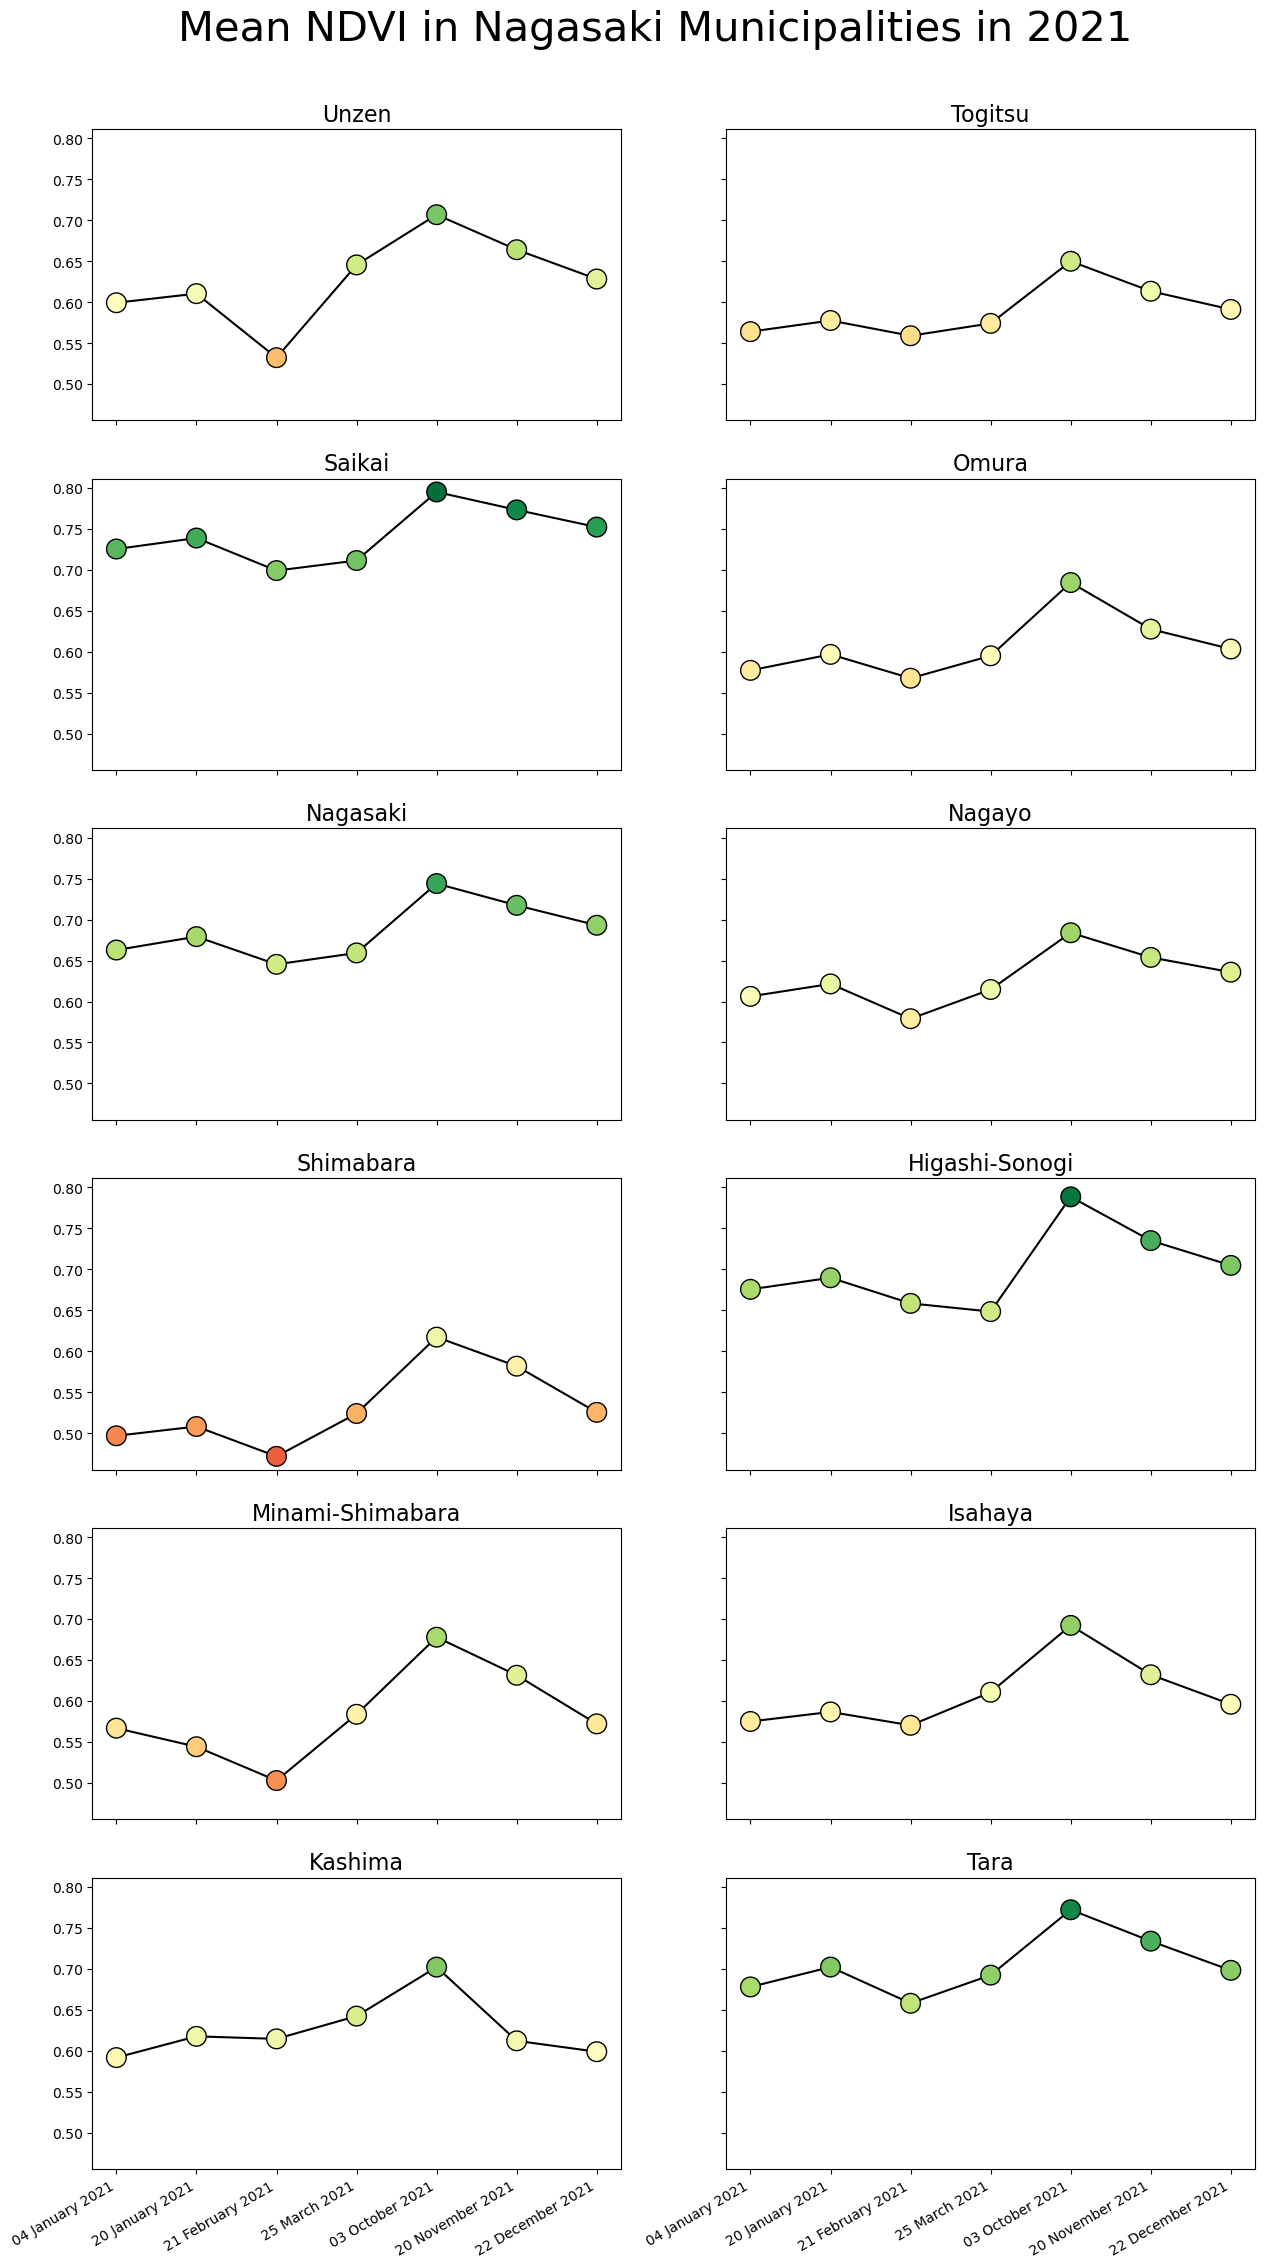

In [155]:
# Create graphs based on the results.
# Note that there's a dip in February potentially due to cloud cover

f, axs = plt.subplots(nrows = 6, ncols = 2, figsize = (15,30), sharey = True)

axs = axs.flatten()
# automatically format date
f.autofmt_xdate()

# Define a colormap (e.g., 'viridis' for a perceptually uniform colormap)
colormap = plt.get_cmap('RdYlGn')

# Normalize y-values to map to the colormap
norm = plt.Normalize(0.4, 0.8)

for idx, row in geometries.iterrows():
    axs[idx].plot(ndvi_time.date, row[3:16:2], zorder = 0, c = 'k')
    
    # use this to color the markers based on the y-value
    axs[idx].scatter(ndvi_time.date, row[3:16:2], marker = 'o', s = 200, edgecolor = 'k',
                  c=row[3:16:2].values.astype(np.float32), cmap = colormap, norm = norm,
                    zorder = 4)
    
    axs[idx].set_title(row.iloc[0], fontsize = 16)
    
plt.suptitle('Mean NDVI in Nagasaki Municipalities in 2021', x = 0.5, y = 0.92, fontsize = 30)

Text(0.5, 0.92, 'Median NDVI in Nagasaki Municipalities in 2021')

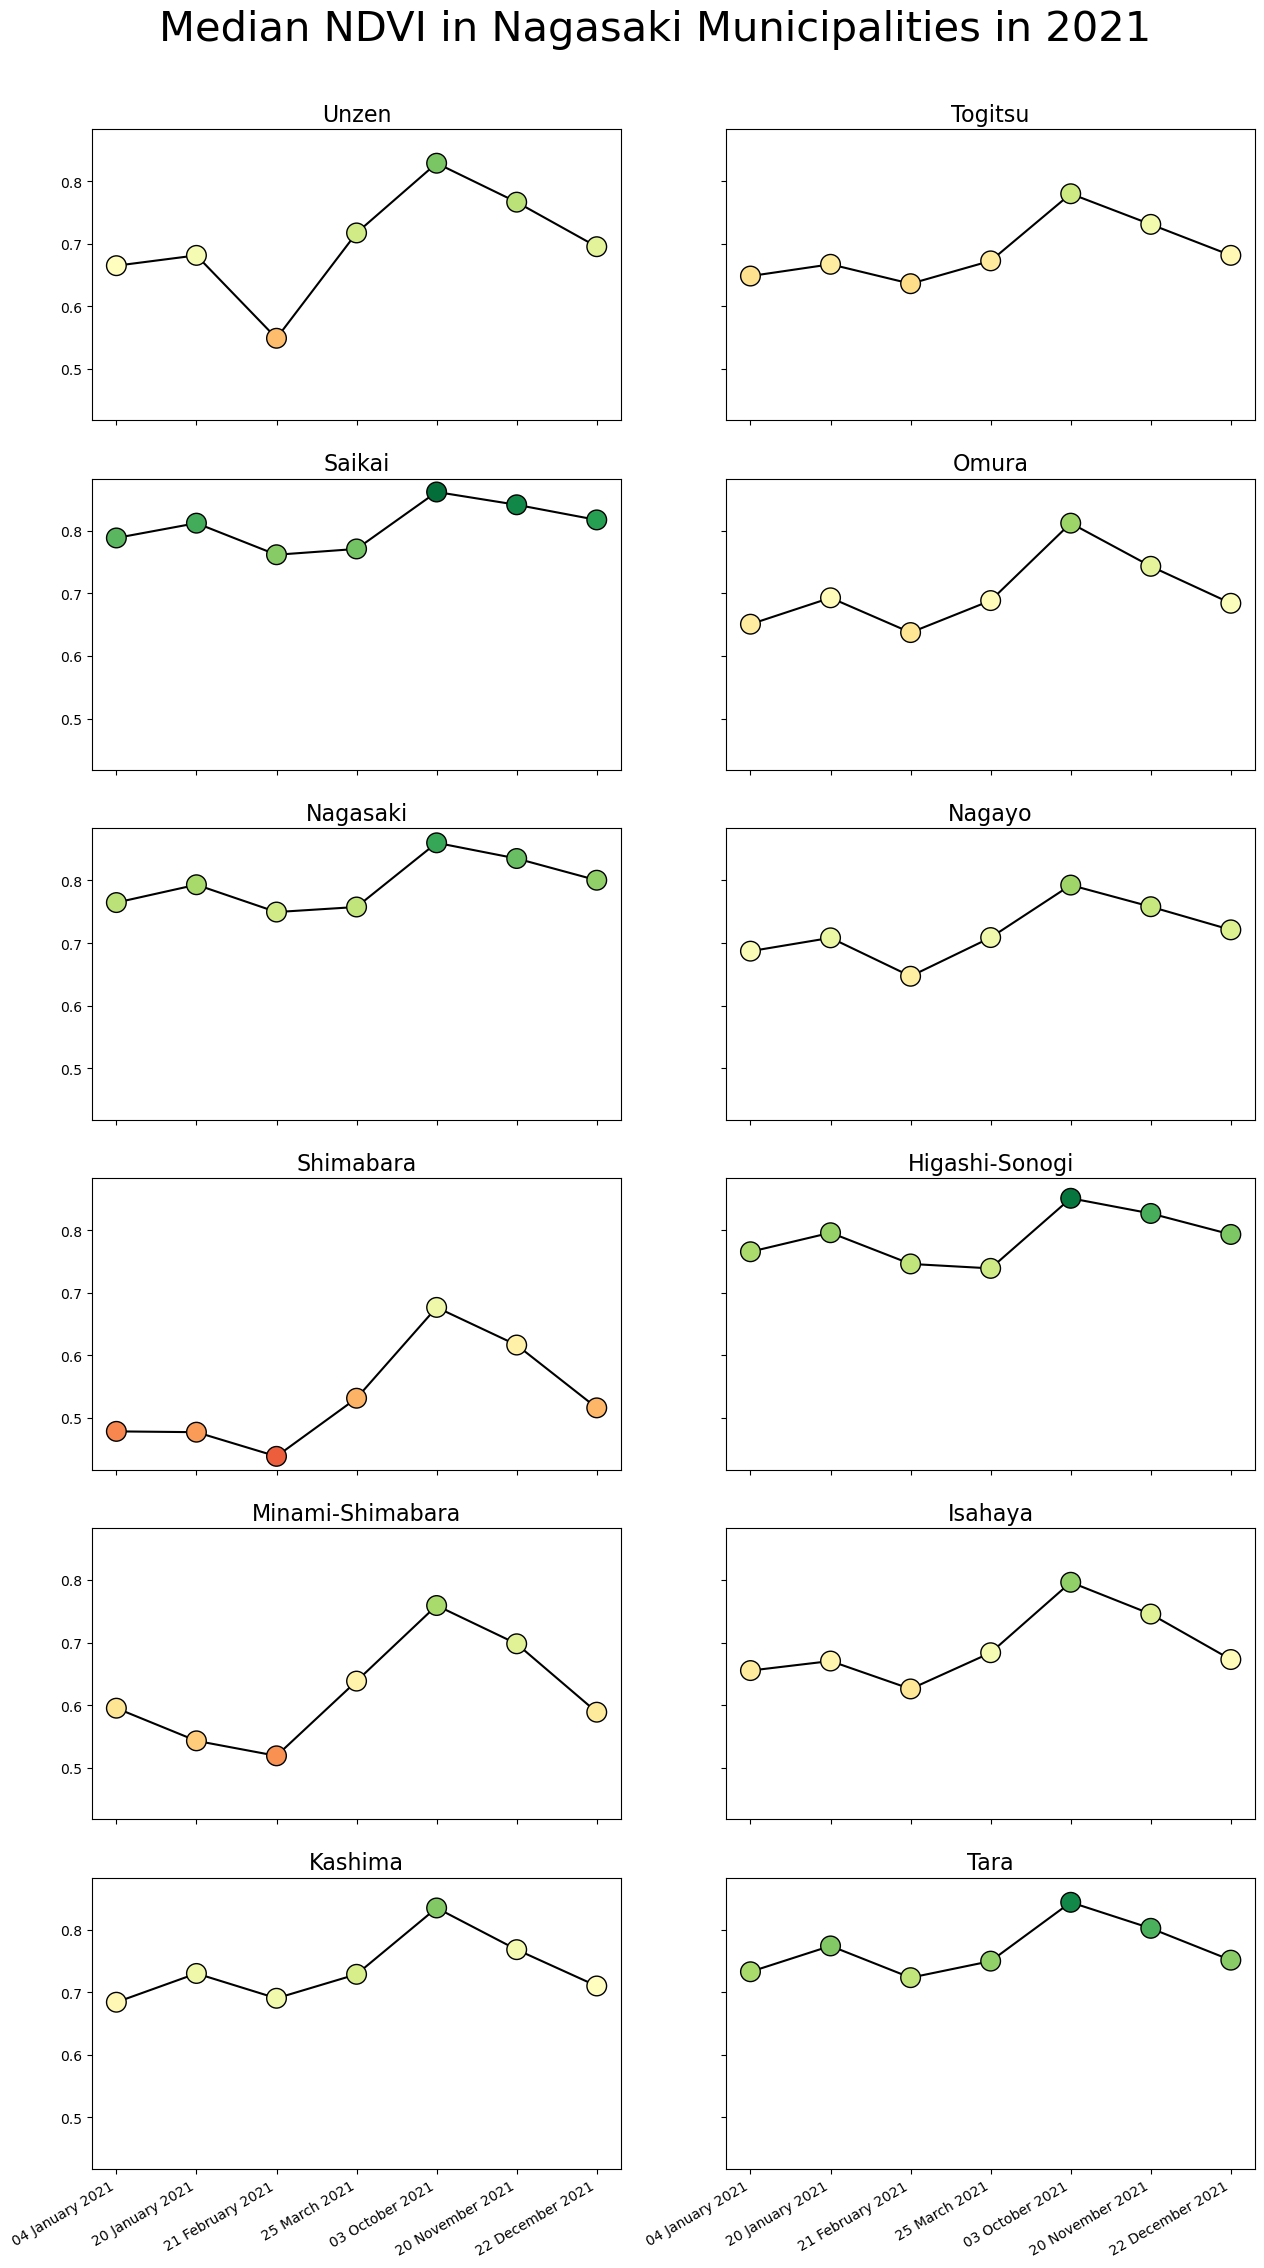

In [153]:
f, axs = plt.subplots(nrows = 6, ncols = 2, figsize = (15,30), sharey = True)

axs = axs.flatten()
f.autofmt_xdate()

# Define a colormap (e.g., 'viridis' for a perceptually uniform colormap)
colormap = plt.get_cmap('RdYlGn')

# Normalize y-values to map to the colormap
norm = plt.Normalize(0.4, 0.8)

for idx, row in geometries.iterrows():
    axs[idx].plot(ndvi_time.date, row[4:17:2], zorder = 0, c = 'k')
    
    axs[idx].scatter(ndvi_time.date, row[4:17:2], marker = 'o', s = 200, edgecolor = 'k',
                  c=row[3:16:2].values.astype(np.float32), cmap = colormap, norm = norm,
                    zorder = 4)
    
    axs[idx].set_title(row.iloc[0], fontsize = 16)
    
plt.suptitle('Median NDVI in Nagasaki Municipalities in 2021', x = 0.5, y = 0.92, fontsize = 30)

In [156]:
# save data
ndvi_masked.rio.to_raster('outputs/ndvi_masked.tif')

In [160]:
# save data
geometries.to_file('outputs/mun_mean_median_ndvi_masked.geojson', driver = 'GeoJSON')

In [5]:
with rxr.open_rasterio(files[0], masked = True).rio.clip(geometries.geometry, from_disk = True) as ds:
    test = ds

In [11]:
optical = test[:-1] * 0.0000275 - 0.2

optical = optical.clip(min = 0, max = 1, keep_attrs= True)

ndvi = (optical[4] - optical[3]) / (optical[4] + optical[3])

ndvi

<xarray.DataArray (y: 2164, x: 2664)>
array([[nan, nan, nan, ..., nan, nan, nan],
       [nan, nan, nan, ..., nan, nan, nan],
       [nan, nan, nan, ..., nan, nan, nan],
       ...,
       [nan, nan, nan, ..., nan, nan, nan],
       [nan, nan, nan, ..., nan, nan, nan],
       [nan, nan, nan, ..., nan, nan, nan]])
Coordinates:
  * x            (x) float64 5.5e+05 5.5e+05 5.501e+05 ... 6.299e+05 6.299e+05
  * y            (y) float64 3.666e+06 3.666e+06 ... 3.602e+06 3.602e+06
    spatial_ref  int32 0

In [58]:
masks = list()

for cl_mask in cl_masks:
    with rxr.open_rasterio(cl_mask, masked = True).rio.clip(geometries.geometry, from_disk = True) as ds:
        data = ds.astype(np.uint16).squeeze()
        result = run_qa_parser(data, qa_pixel_interp_conservative)
        masks.append(result)
        ds.close()

In [60]:
stacked_masks = np.stack(masks)

ndvi_masked = ndvi_time.where(np.invert(stacked_masks), np.nan)

ndvi_masked.plot(col = 'date', col_wrap = 2, cmap = 'RdYlGn')

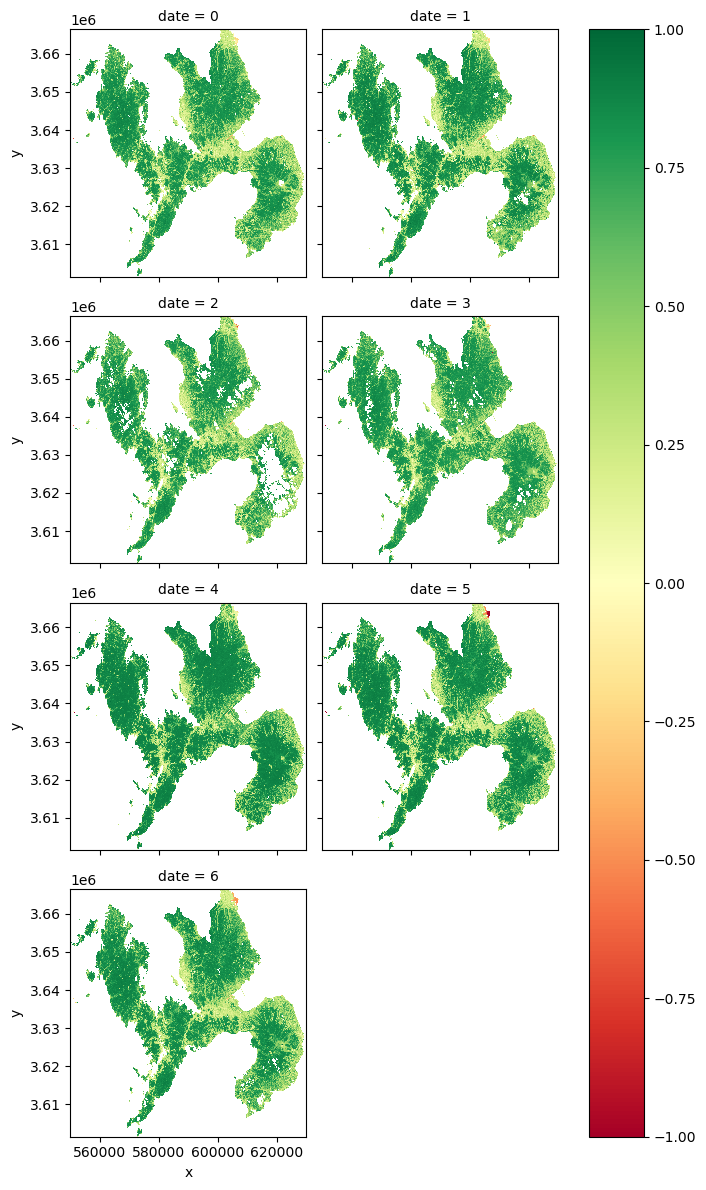

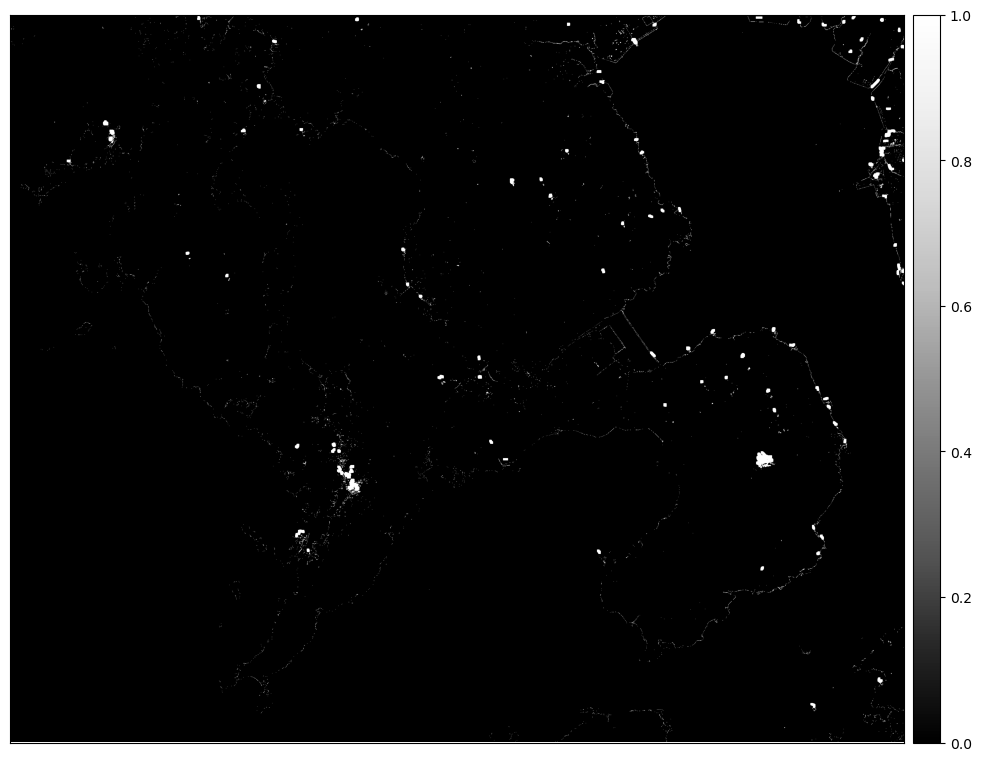

<Axes: >

In [51]:
import earthpy.plot as ep
ep.plot_bands(result)

In [33]:
unique_vals = np.unique(test.data.astype(np.uint16))

In [31]:
def apply_array_func(func, x):
    '''
    Applies a function element-wise across a 1D array
    '''
    return np.array([func(xi) for xi in x])

In [34]:
unique_vals

array([21762, 21824, 21890, 21952, 22018, 22080, 22146, 22208, 22280,
       23826, 23888, 24082, 24144, 29986, 30048, 30242, 30304, 54724],
      dtype=uint16)